# Predicting Teacher Turnover

__Meaghan Ross__

Flatiron School Capstone

### Business Understanding

### Data Understanding

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,\
plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate

### Data Preparation

In [2]:
ls data/

SPR_SY1415_School_Metric_Scores_20160208.xlsx
SPR_SY1516_School_Metric_Scores_20170203.xlsx
SPR_SY1617_School_Metric_Scores_20180206.xlsx
SPR_SY1718_School_Metric_Scores_20190129.xlsx
SPR_SY1819_School_Metric_Scores_20200127.xlsx
df_2019
df_2019.csv
employee_information_April2015.csv
employee_information_April2016.csv
employee_information_April2017.csv
employee_information_April2018.csv
employee_information_April2019.csv
employee_information_April2020.csv
employee_information_April2021.csv
full_data.csv


In [3]:
df = pd.read_csv('data/df_2019.csv', index_col=0)

In [4]:
df.head()

,LAST_NAME,FIRST_NAME,PAY_RATE,TITLE_DESCRIPTION,HOME_ORGANIZATION,ORGANIZATION_LEVEL,GENDER,School,Turnaround Model,Enrollment,...,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score,NEW_TEACHER,TURNOVER
0,ABAYOMI-IGE,OLABIMPE,90051,"TEACHER,SPEC EDUCATION",5070.0,HIGH SCHOOL,F,Parkway Northwest High School,None,260.0,...,48,WATCH,73.0,REINFORCE,18.0,INTERVENE,67,33,0,0
1,ABBOTT,JOYCE,76461,"TEACHER,FULL TIME",1290.0,ELEMENTARY SCHOOL,F,Andrew Hamilton School,None,532.0,...,0,INTERVENE,0.0,INTERVENE,1.0,INTERVENE,46,0,0,0
2,ABDUL-LATEEF,VILLIA,56531,"TEACHER,FULL TIME",1010.0,HIGH SCHOOL,F,John Bartram High School,None,561.0,...,52,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,52,43,0,1
3,ABDULALEEM,MUHAMMAD,70564,"TEACHER,FULL TIME",6090.0,CAREER AND TECHNICAL HIGH SCHL,M,A. Philip Randolph Career and Technical High S...,None,493.0,...,56,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,64,36,0,0
4,ABDULLAH,AARON,46694,"TEACHER,FULL TIME",6360.0,ELEMENTARY SCHOOL,M,Theodore Roosevelt School,Turnaround,525.0,...,47,WATCH,63.0,REINFORCE,10.0,INTERVENE,58,51,1,0


## EDA

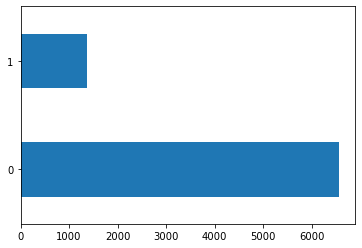

In [5]:
df['NEW_TEACHER'].value_counts().plot.barh();

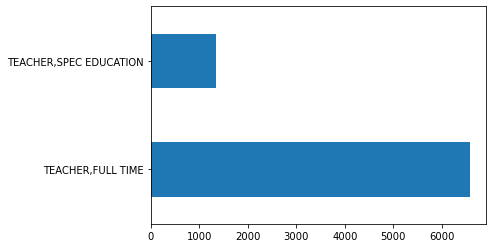

In [6]:
df['TITLE_DESCRIPTION'].value_counts().plot.barh();

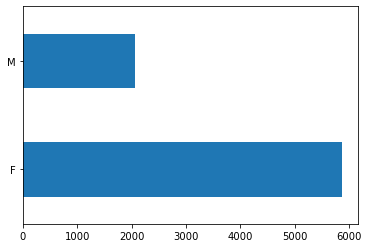

In [7]:
df['GENDER'].value_counts().plot.barh();

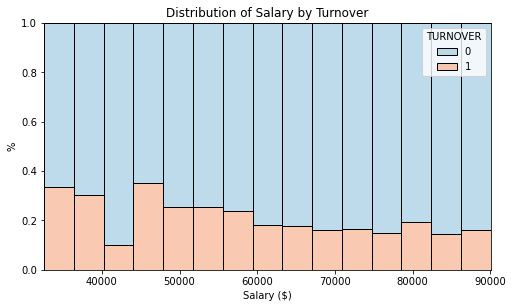

In [8]:
f = plt.figure(figsize=(8,10))
ax = f.add_subplot(2,1,1)

sns.histplot(data=df, ax=ax, stat='probability', multiple="fill",
             x="PAY_RATE", palette = 'RdBu_r',
             hue="TURNOVER", element="bars", 
             legend=True, bins=15)
ax.set_title("Distribution of Salary by Turnover")
ax.set_xlabel("Salary ($)")
ax.set_ylabel("%");

In [9]:
df.corr()

,PAY_RATE,HOME_ORGANIZATION,Enrollment,Clim Score,Attendance (95%+) Score,Retention Score,ISS Score,OSS Score,Parent Survey Climate Score,Parent Survey Participation Score,Teacher Attendance Score,NEW_TEACHER,TURNOVER
PAY_RATE,1.000000,0.038187,0.084483,0.124878,0.101647,0.100311,0.023937,0.094068,0.030273,-0.017216,0.052436,-0.716830,-0.128383
HOME_ORGANIZATION,0.038187,1.000000,0.420716,0.161885,0.042418,0.180387,-0.048261,0.164868,-0.046431,-0.055446,0.005062,-0.021044,-0.040983
Enrollment,0.084483,0.420716,1.000000,0.154257,0.089632,0.188510,-0.193487,0.054606,-0.158786,-0.197453,0.017680,-0.066778,-0.074059
Clim Score,0.124878,0.161885,0.154257,1.000000,0.884434,0.889190,0.123755,0.685835,0.248483,0.192925,0.439631,-0.112942,-0.147260
Attendance (95%+) Score,0.101647,0.042418,0.089632,0.884434,1.000000,0.755330,0.120543,0.644979,0.203678,0.119316,0.367596,-0.094704,-0.111212
Retention Score,0.100311,0.180387,0.188510,0.889190,0.755330,1.000000,0.034136,0.583733,0.149625,0.124893,0.483844,-0.094468,-0.146313
ISS Score,0.023937,-0.048261,-0.193487,0.123755,0.120543,0.034136,1.000000,0.211967,0.046071,0.056472,0.051395,-0.016847,0.022632
OSS Score,0.094068,0.164868,0.054606,0.685835,0.644979,0.583733,0.211967,1.000000,0.319913,0.247719,0.272244,-0.105428,-0.103168
Parent Survey Climate Score,0.030273,-0.046431,-0.158786,0.248483,0.203678,0.149625,0.046071,0.319913,1.000000,0.642356,0.185495,-0.007046,-0.029399
Parent Survey Participation Score,-0.017216,-0.055446,-0.197453,0.192925,0.119316,0.124893,0.056472,0.247719,0.642356,1.000000,0.174428,0.022961,-0.023279


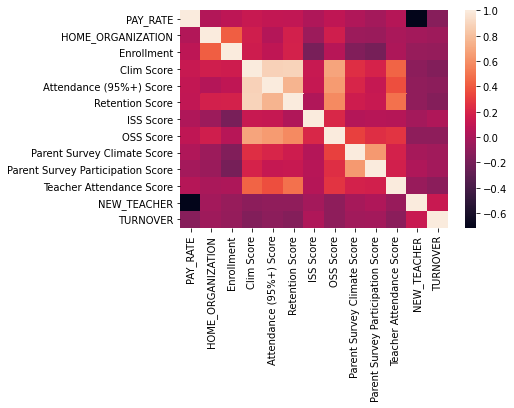

In [10]:
sns.heatmap(df.corr());

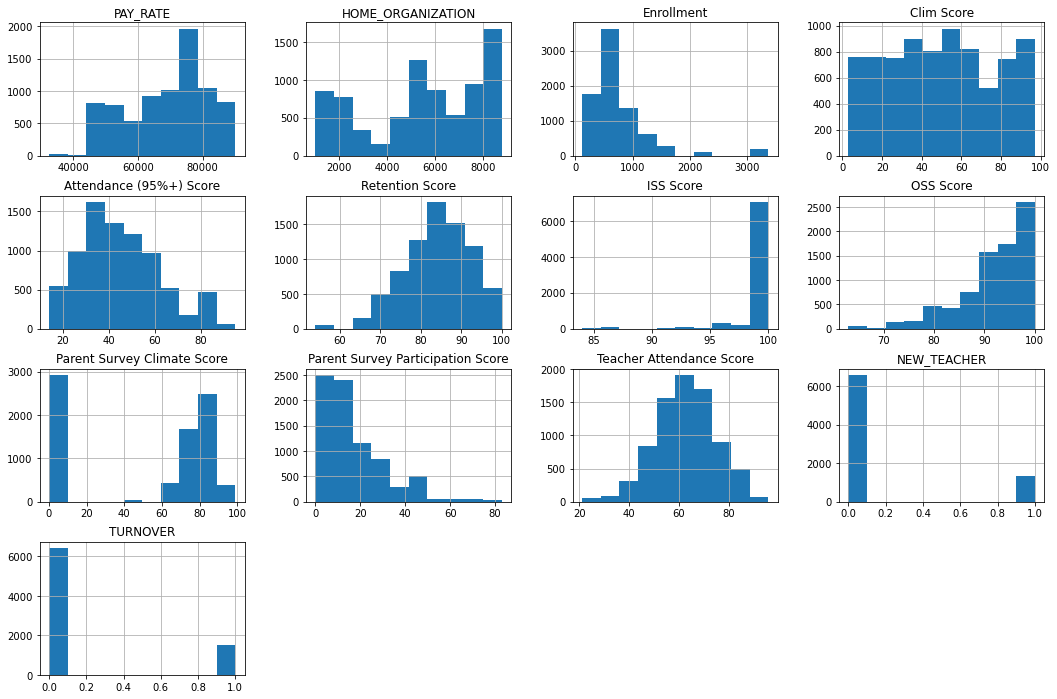

In [11]:
df.hist(figsize=(18, 12));


### Preprocessing

In [12]:
df.head()

,LAST_NAME,FIRST_NAME,PAY_RATE,TITLE_DESCRIPTION,HOME_ORGANIZATION,ORGANIZATION_LEVEL,GENDER,School,Turnaround Model,Enrollment,...,Student Survey Climate Score,Student Survey Climate Tier,Parent Survey Climate Score,Parent Survey Climate Tier,Parent Survey Participation Score,Parent Survey Participation Tier,Teacher Attendance Score,Student Survey Teaching Score,NEW_TEACHER,TURNOVER
0,ABAYOMI-IGE,OLABIMPE,90051,"TEACHER,SPEC EDUCATION",5070.0,HIGH SCHOOL,F,Parkway Northwest High School,None,260.0,...,48,WATCH,73.0,REINFORCE,18.0,INTERVENE,67,33,0,0
1,ABBOTT,JOYCE,76461,"TEACHER,FULL TIME",1290.0,ELEMENTARY SCHOOL,F,Andrew Hamilton School,None,532.0,...,0,INTERVENE,0.0,INTERVENE,1.0,INTERVENE,46,0,0,0
2,ABDUL-LATEEF,VILLIA,56531,"TEACHER,FULL TIME",1010.0,HIGH SCHOOL,F,John Bartram High School,None,561.0,...,52,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,52,43,0,1
3,ABDULALEEM,MUHAMMAD,70564,"TEACHER,FULL TIME",6090.0,CAREER AND TECHNICAL HIGH SCHL,M,A. Philip Randolph Career and Technical High S...,None,493.0,...,56,REINFORCE,0.0,INTERVENE,2.0,INTERVENE,64,36,0,0
4,ABDULLAH,AARON,46694,"TEACHER,FULL TIME",6360.0,ELEMENTARY SCHOOL,M,Theodore Roosevelt School,Turnaround,525.0,...,47,WATCH,63.0,REINFORCE,10.0,INTERVENE,58,51,1,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7927 entries, 0 to 8251
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LAST_NAME                          7927 non-null   object 
 1   FIRST_NAME                         7927 non-null   object 
 2   PAY_RATE                           7927 non-null   int64  
 3   TITLE_DESCRIPTION                  7927 non-null   object 
 4   HOME_ORGANIZATION                  7927 non-null   float64
 5   ORGANIZATION_LEVEL                 7927 non-null   object 
 6   GENDER                             7927 non-null   object 
 7   School                             7927 non-null   object 
 8   Turnaround Model                   7927 non-null   object 
 9   Enrollment                         7927 non-null   float64
 10  Grades Served                      7927 non-null   object 
 11  Admissions Type                    7927 non-null   objec

In [14]:
drop_modeling = ['LAST_NAME', 'FIRST_NAME', 'HOME_ORGANIZATION', 'School', 'Overall Tier',
                 'Ach Tier', 'Prog Tier', 'Clim Tier', 'Attendance (95%+) Tier', 
                 'Retention Tier', 'ISS Tier', 'OSS Tier', 'Student Survey Climate Tier',
                 'Parent Survey Climate Tier', 'Parent Survey Participation Tier', 'TURNOVER']

In [15]:
X = df.drop(drop_modeling, axis=1)
y = df['TURNOVER']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [16]:
X_train.shape

(5945, 22)

There are some columns that are listed as objects when they should be numerical.

In [17]:
obj_to_num = ['Student Survey Climate Score', 'Student Survey Teaching Score', 
                  'Overall Score', 'Ach Score', 'Prog Score']

In [18]:
def na_transformer(df):
    '''
    Changes values to 0 for columns that have 
    'Not Applicable' or 'Insufficient Data' preventing them from becoming numerical.
    '''
    for col in obj_to_num:
        df.loc[(df[col] == 'Not Applicable'), col] = 0
        df.loc[(df[col] == 'Insufficient Data'), col] = 0
    return df

In [19]:
def to_float_transformer(df):
    '''
    Ensure all 'Score' columns are float, and all int64 are also float.
    '''
    for col in obj_to_num:
        df[col] = df[col].astype('float64')
    for col in [df.select_dtypes('int64').columns]:
        df[col] = df[col].astype('float64')
    return df

In [20]:
cat_columns = ['TITLE_DESCRIPTION', 'ORGANIZATION_LEVEL', 'GENDER', 'Turnaround Model',
               'Grades Served', 'Admissions Type']

# OneHotEncode the columns as part of cleaning
# to avoid needing to separate numerical and categorical
# columns later
ohe_col_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first', sparse=False), cat_columns)],
                                 remainder='passthrough')

# Apply all our cleaning functions, then finish with ohe
cleaning_pipeline = Pipeline(steps=[
    ('na_trans', FunctionTransformer(na_transformer)),
    ('float', FunctionTransformer(to_float_transformer)),
    ('ohe_trans', ohe_col_trans)
])

In [21]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-19-4e71e321aa9c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('float64')
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [22]:
ohe_feature_names = cleaning_pipeline.steps[-1][1].get_feature_names()

In [23]:
ohe_feature_names

['ohe__x0_TEACHER,SPEC EDUCATION',
 'ohe__x1_ELEMENTARY SCHOOL',
 'ohe__x1_HIGH SCHOOL',
 'ohe__x1_MIDDLE SCHOOL',
 'ohe__x2_M',
 'ohe__x3_School Redesign Initiative',
 'ohe__x3_Turnaround',
 "ohe__x4_'5-6'",
 "ohe__x4_'5-8'",
 "ohe__x4_'6-8'",
 "ohe__x4_'7-8'",
 "ohe__x4_'9-12'",
 "ohe__x4_'K-2'",
 "ohe__x4_'K-4'",
 "ohe__x4_'K-5'",
 "ohe__x4_'K-6'",
 "ohe__x4_'K-7'",
 "ohe__x4_'K-8'",
 'ohe__x5_Neighborhood',
 'ohe__x5_Special Admit',
 'PAY_RATE',
 'Enrollment',
 'Overall Score',
 'Ach Score',
 'Prog Score',
 'Clim Score',
 'Attendance (95%+) Score',
 'Retention Score',
 'ISS Score',
 'OSS Score',
 'Student Survey Climate Score',
 'Parent Survey Climate Score',
 'Parent Survey Participation Score',
 'Teacher Attendance Score',
 'Student Survey Teaching Score',
 'NEW_TEACHER']

### Modeling

Many models were created for this project. The `DummyClassifier` was used as baseline model. In order to improve on that baseline, we designed `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, and `XGBoost` models, with and without using SMOTE, to counteract class imbalances. 

For each model we will build a pipeline using `StandardScaler` and the model of choice. Then we will evaluate the model by running the pipeline through our print_cv_scores function and then gathering metrics for model efficacy.

Through the model iteration process we are seeking to maximize the recall score by minimizing the number of false negatives, meaning teachers who were predicted to stay and actually end up leaving. By focusing on recall, we are trying to reduce the chances of the model missing a teacher who actually leaves their school the following year.


In [39]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and binary target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','recall']
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Recall:', results['train_recall'].mean())
    print('Cross_Val Recall:', results['test_recall'].mean())


#### Dummy Classifier

In [86]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='most_frequent'))
])

In [87]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

[0.81055509 0.81055509 0.81055509 0.81055509 0.81076535]
Training Accuracy 0.8105971404541631
##############
[0.81076535 0.81076535 0.81076535 0.81076535 0.80992431]
Cross_Val Accuracy 0.8105971404541631
##############
Training Recall: 0.0
Cross_Val Recall: 0.0


In [88]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='stratified'))
])
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('dc', DummyClassifier(strategy='stratified'))])

In [89]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

[0.70353238 0.69091674 0.69995795 0.68124474 0.69238856]
Training Accuracy 0.6936080740117746
##############
[0.67872161 0.686291   0.70058873 0.68713204 0.67199327]
Cross_Val Accuracy 0.6849453322119428
##############
Training Recall: 0.19271895424836602
Cross_Val Recall: 0.18740216322517206


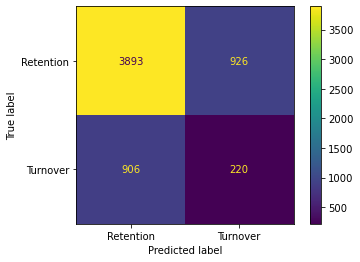

In [132]:
plot_confusion_matrix(dummy_pipe, X_train_clean, y_train, 
                      display_labels= ['Retention', 'Turnover']);

The dummy classifier is having a difficult time predicting the actual turnover. 

#### Logistic Regression

In [91]:
lr_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])
lr_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr', LogisticRegression(random_state=42))])

In [92]:
print_cv_scores(lr_pipe, X_train_clean, y_train)

[0.81202691 0.80971405 0.81202691 0.81034483 0.81244743]
Training Accuracy 0.8113120269133726
##############
[0.80992431 0.81076535 0.80656013 0.80992431 0.81076535]
Cross_Val Accuracy 0.809587888982338
##############
Training Recall: 0.018871377481810333
Cross_Val Recall: 0.015099311701081614


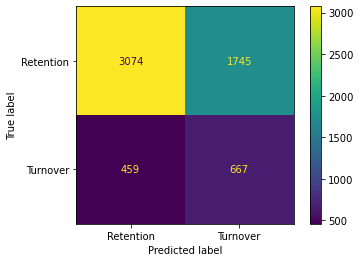

In [131]:
plot_confusion_matrix(lr_pipe, X_train_clean, y_train, 
                      display_labels= ['Retention', 'Turnover']);

In a Logistic Regression model with default parameters, we can see that it has a really hard time classifying the minority class likely due to the class imbalance, so let's iterate this model to try to improve the recall scores.

In [95]:
lr_pipe1 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              random_state=42))
])
lr_pipe1.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [96]:
print_cv_scores(lr_pipe1, X_train_clean, y_train)

[0.63351556 0.62552565 0.64423886 0.63624895 0.62678722]
Training Accuracy 0.6332632464255676
##############
[0.61900757 0.62910008 0.61816653 0.59966358 0.6391926 ]
Cross_Val Accuracy 0.6210260723296888
##############
Training Recall: 0.5990218275989642
Cross_Val Recall: 0.5736755162241887


/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


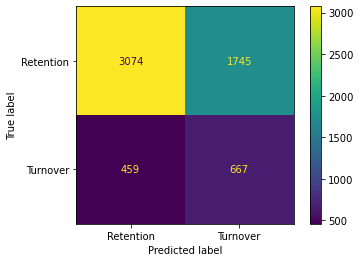

In [130]:
plot_confusion_matrix(lr_pipe1, X_train_clean, y_train, 
                      display_labels= ['Retention', 'Turnover']);

By setting the `class_weight` hyperparameter to balanced, this helps for the logistic regression model to better classify the minority class and the recall score increases by over 50%.

Let's set up a grid search to find the best hyperparameters to maximize the recall score.

In [102]:
lr_grid_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              n_jobs = -1,
                              random_state=42))
])

In [104]:
grid = {'lr__tol': [1e-5,1e-4,1e-3],
        'lr__C' : [1e-5,1e-3,1e-1, 1, 100],
        'lr__max_iter':[1e3, 1e5]
       }

In [106]:
gridsearch = GridSearchCV(lr_grid_pipe, 
                          grid, 
                          return_train_score=True, 
                          scoring='recall',
                          verbose=2)

gridsearch.fit(X_train_clean, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05, total=   1.0s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .. lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.5s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05 .................
[CV] .. lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.5s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05 .................
[CV] .. lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.5s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05 .................
[CV] .. lr__C=1e-05, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.6s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001 ................
[CV] . lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001, total=   0.2s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001 ................
[CV] . lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001, total=   0.5s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001 ................
[CV] . lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001, total=   0.5s
[CV] lr__C=1e-05, lr__max_iter=1000.0, lr__tol=0.0001 ................
[CV] .

[CV]  lr__C=0.001, lr__max_iter=100000.0, lr__tol=0.001, total=   0.6s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=0.1, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=0.0001 ..................
[CV] ... lr__C=0.1, lr__max_iter=1000.0, lr__tol=0.0001, total=   0.2s
[CV] lr__C=0.1, lr__max_iter=1000.0, lr__tol=0.0001 ..................
[CV] .

[CV] .... lr__C=1, lr__max_iter=100000.0, lr__tol=0.001, total=   0.2s
[CV] lr__C=1, lr__max_iter=100000.0, lr__tol=0.001 ...................
[CV] .... lr__C=1, lr__max_iter=100000.0, lr__tol=0.001, total=   0.2s
[CV] lr__C=1, lr__max_iter=100000.0, lr__tol=0.001 ...................
[CV] .... lr__C=1, lr__max_iter=100000.0, lr__tol=0.001, total=   0.6s
[CV] lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .... lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05, total=   0.2s
[CV] lr__C=100, lr__max_iter=1000.0, lr__tol=1e-05 ...................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   46.4s finished


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           n_jobs=-1,
                                                           random_state=42))]),
             param_grid={'lr__C': [1e-05, 0.001, 0.1, 1, 100],
                         'lr__max_iter': [1000.0, 100000.0],
                         'lr__tol': [1e-05, 0.0001, 0.001]},
             return_train_score=True, scoring='recall', verbose=2)

In [108]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__max_iter,param_lr__tol,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.606416,0.195468,0.004283,0.001546,1e-05,1000,1e-05,"{'lr__C': 1e-05, 'lr__max_iter': 1000.0, 'lr__...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
1,0.438056,0.148570,0.003267,0.002007,1e-05,1000,0.0001,"{'lr__C': 1e-05, 'lr__max_iter': 1000.0, 'lr__...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
2,0.356480,0.180914,0.002858,0.002423,1e-05,1000,0.001,"{'lr__C': 1e-05, 'lr__max_iter': 1000.0, 'lr__...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
3,0.221332,0.168011,0.002356,0.002479,1e-05,100000,1e-05,"{'lr__C': 1e-05, 'lr__max_iter': 100000.0, 'lr...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
4,0.224312,0.165704,0.001618,0.000886,1e-05,100000,0.0001,"{'lr__C': 1e-05, 'lr__max_iter': 100000.0, 'lr...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
5,0.311214,0.205172,0.002748,0.002311,1e-05,100000,0.001,"{'lr__C': 1e-05, 'lr__max_iter': 100000.0, 'lr...",0.613333,0.595556,...,0.598572,0.015954,1,0.612653,0.604883,0.608213,0.621532,0.613333,0.612123,0.005621
6,0.139141,0.006304,0.001196,0.000211,0.001,1000,1e-05,"{'lr__C': 0.001, 'lr__max_iter': 1000.0, 'lr__...",0.582222,0.582222,...,0.575457,0.035956,7,0.586016,0.581576,0.580466,0.597114,0.595556,0.588146,0.006957
7,0.397007,0.198625,0.004513,0.002783,0.001,1000,0.0001,"{'lr__C': 0.001, 'lr__max_iter': 1000.0, 'lr__...",0.582222,0.582222,...,0.575457,0.035956,7,0.586016,0.581576,0.580466,0.597114,0.595556,0.588146,0.006957
8,0.280651,0.181684,0.002305,0.001733,0.001,1000,0.001,"{'lr__C': 0.001, 'lr__max_iter': 1000.0, 'lr__...",0.582222,0.582222,...,0.575457,0.035956,7,0.586016,0.581576,0.580466,0.597114,0.595556,0.588146,0.006957
9,0.225288,0.170384,0.002283,0.002393,0.001,100000,1e-05,"{'lr__C': 0.001, 'lr__max_iter': 100000.0, 'lr...",0.582222,0.582222,...,0.575457,0.035956,7,0.586016,0.581576,0.580466,0.597114,0.595556,0.588146,0.006957


In [109]:
gridsearch.best_params_

{'lr__C': 1e-05, 'lr__max_iter': 1000.0, 'lr__tol': 1e-05}

From these results, it seems that the logistic regression model likes higher regularization with the smallest C performing best, as well as the smallest tolerance. Let's run it again with different penalty types and some smaller C and tolerance levels.

In [114]:
lr_grid_pipe1 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              max_iter = 1000,
                              solver = 'liblinear',
                              random_state=42))
])

In [115]:
grid1 = {'lr__tol': [1e-6, 1e-5, 1e-4],
        'lr__C' : [1e-7, 1e-5, 1e-3],
        'lr__penalty':['l1', 'l2']
        }

In [116]:
gridsearch1 = GridSearchCV(lr_grid_pipe1, 
                          grid1, 
                          return_train_score=True, 
                          scoring='recall',
                          verbose=2)

gridsearch1.fit(X_train_clean, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l1, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l1, lr__tol=1e-05 ......................
[CV] ....... lr_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-06, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=1e-07, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=1e-07, lr__penalty=l2, lr__tol=0.0001, total=   0.0s
[CV] lr__C=1e-07, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] .

[CV] ....... lr__C=0.001, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=1e-05 ......................
[CV] ....... lr__C=0.001, lr__penalty=l2, lr__tol=1e-05, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=0.001, lr__penalty=l2, lr__tol=0.0001, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=0.001, lr__penalty=l2, lr__tol=0.0001, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=0.001, lr__penalty=l2, lr__tol=0.0001, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=0.001, lr__penalty=l2, lr__tol=0.0001, total=   0.0s
[CV] lr__C=0.001, lr__penalty=l2, lr__tol=0.0001 .....................
[CV] ...... lr__C=0.001, lr__penalty=l2, lr__tol=0.0001, total=   0.0s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.9s finished


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': [1e-07, 1e-05, 0.001],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__tol': [1e-06, 1e-05, 0.0001]},
             return_train_score=True, scoring='recall', verbose=2)

In [117]:
pd.DataFrame(gridsearch1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_lr__tol,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009738,0.002933,0.001480,0.000467,1e-07,l1,1e-06,"{'lr__C': 1e-07, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.005925,0.000437,0.001088,0.000334,1e-07,l1,1e-05,"{'lr__C': 1e-07, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.005570,0.000300,0.000856,0.000052,1e-07,l1,0.0001,"{'lr__C': 1e-07, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.005755,0.000206,0.000933,0.000205,1e-07,l2,1e-06,"{'lr__C': 1e-07, 'lr__penalty': 'l2', 'lr__tol...",0.671111,0.684444,...,0.668751,0.009522,1,0.675916,0.660377,0.673696,0.687014,0.673333,0.674067,0.008475
4,0.006046,0.000198,0.001074,0.000304,1e-07,l2,1e-05,"{'lr__C': 1e-07, 'lr__penalty': 'l2', 'lr__tol...",0.671111,0.684444,...,0.668751,0.009522,1,0.675916,0.660377,0.673696,0.687014,0.673333,0.674067,0.008475
5,0.005697,0.000022,0.000845,0.000014,1e-07,l2,0.0001,"{'lr__C': 1e-07, 'lr__penalty': 'l2', 'lr__tol...",0.671111,0.684444,...,0.668751,0.009522,1,0.675916,0.660377,0.673696,0.687014,0.673333,0.674067,0.008475
6,0.005269,0.000136,0.000815,0.000017,1e-05,l1,1e-06,"{'lr__C': 1e-05, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.005363,0.000135,0.000823,0.000011,1e-05,l1,1e-05,"{'lr__C': 1e-05, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.005524,0.000209,0.000862,0.000062,1e-05,l1,0.0001,"{'lr__C': 1e-05, 'lr__penalty': 'l1', 'lr__tol...",0.000000,0.000000,...,0.000000,0.000000,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.006995,0.000239,0.000884,0.000060,1e-05,l2,1e-06,"{'lr__C': 1e-05, 'lr__penalty': 'l2', 'lr__tol...",0.671111,0.684444,...,0.666085,0.010697,4,0.674806,0.659267,0.671476,0.687014,0.672222,0.672957,0.008845


In [119]:
gridsearch1.best_params_

{'lr__C': 1e-07, 'lr__penalty': 'l2', 'lr__tol': 1e-06}

Higher regularization strength and lower tolerance allows this logistic regression model to perform the best.

It looks like the l2 penalty continues to perform the best, let's just check to see the scores using different solvers.

In [120]:
lr_grid_pipe2 = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              max_iter = 1000,
                              C = 1e-7,
                              tol = 1e-6,
                              random_state=42))
])

In [121]:
grid2 = {'lr__solver': ['liblinear', 'lbfgs']}

In [122]:
gridsearch2 = GridSearchCV(lr_grid_pipe2, 
                          grid2, 
                          return_train_score=True, 
                          scoring='recall',
                          verbose=2)

gridsearch2.fit(X_train_clean, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] lr__solver=liblinear ............................................
[CV] ............................. lr__solver=liblinear, total=   0.0s
[CV] lr__solver=liblinear ............................................
[CV] ............................. lr__solver=liblinear, total=   0.0s
[CV] lr__solver=liblinear ............................................
[CV] ............................. lr__solver=liblinear, total=   0.0s
[CV] lr__solver=liblinear ............................................
[CV] ............................. lr__solver=liblinear, total=   0.0s
[CV] lr__solver=liblinear ............................................
[CV] ............................. lr__solver=liblinear, total=   0.0s
[CV] lr__solver=lbfgs ................................................
[CV] ................................. lr__solver=lbfgs, total=   0.0s
[CV] lr__solver=lbfgs ................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(C=1e-07,
                                                           class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           tol=1e-06))]),
             param_grid={'lr__solver': ['liblinear', 'lbfgs']},
             return_train_score=True, scoring='recall', verbose=2)

In [123]:
gridsearch2.best_params_

{'lr__solver': 'liblinear'}

In [124]:
gridsearch2.best_score_

0.6687512291052113

##### Best Logistic Regression Model

In [125]:
best_lr = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced',
                              solver = 'liblinear',
                              C = 1e-07,
                              tol = 1e-06,
                              max_iter=1000,
                              random_state=42))
])
best_lr.fit(X_train_clean, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(C=1e-07, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear', tol=1e-06))])

In [126]:
print_cv_scores(best_lr, X_train_clean, y_train)

[0.54983179 0.56455004 0.55613961 0.54373423 0.5519344 ]
Training Accuracy 0.5532380151387721
##############
[0.52228764 0.568545   0.56686291 0.52817494 0.56097561]
Cross_Val Accuracy 0.5493692178301093
##############
Training Recall: 0.6740673325934148
Cross_Val Recall: 0.6687512291052113


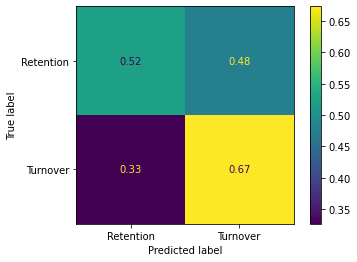

In [135]:
plot_confusion_matrix(best_lr, X_train_clean, y_train, normalize='true',
                      display_labels= ['Retention', 'Turnover']);

### Evaluation